In [1]:
import torch
from torch import nn
import torch.distributions as dist
from torch.utils.data import DataLoader
torch.manual_seed(0)

import matplotlib.pyplot as plt
import numpy as np

In [2]:
POS = 10**(-3)  # try reduce this -> error non-positive definite
EPS = 1e-6
DIAG = 0.1

# One dimensional - direct

### Training

In [3]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=2, num_component_output=2, nsamples=500):
        super(ApproxTruncation, self).__init__()

        self.nsamples = nsamples
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.inp_dim = int(self.num_component_input*(1+self.xdim+self.xdim*(self.xdim+1)/2))
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.inp_dim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

        self.lay = nn.Linear(nsamples, 1)

    def forward(self, samples):

        output = self.network(samples)

        weights = torch.ones(output[:, 0].shape)
        mus = torch.exp(output[:, 1:self.xdim+1])                                                      
        covs = torch.exp(output[:, self.xdim+1:]) + EPS
        
        return weights, mus, covs

#### Generation of a dataset of samples from truncated Gaussians

In [4]:
def generate_random_covariance(dim, lb, ub):
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub)                # strictly positive diagonal
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())                                # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    return cov_matrix


def generate_tgauss_dataset(niter, mean_bounds, sigma_bounds, ncomp, xdim):
    """ generates a list of parameters for truncated Gaussians """
    trunc_gauss = []
    for _ in range(niter):
        weights = torch.rand(ncomp)
        weights = weights / weights.sum()  # Normalize to sum to 1
        means = torch.empty(ncomp, xdim).uniform_(mean_bounds[0], mean_bounds[1])
        covariances = torch.empty(ncomp, xdim, xdim)
        for j in range(ncomp):
            covariances[j] = generate_random_covariance(xdim, sigma_bounds[0], sigma_bounds[1])
        trunc_gauss.append(torch.hstack([weights, means.flatten(), covariances.flatten()]))
    return torch.stack(trunc_gauss)

def _truncate_samples(samples, dist):
    # Iteratively resample until all values are positive
    while torch.any(samples < 0):
        negative_indices = torch.any(samples)
        new_samples = dist.sample((negative_indices.sum(),))
        samples[negative_indices] = new_samples#[negative_indices]
    return samples

def trunc_gauss_sampling(mu, sigma, num_samples):
    
    sampling_dist = dist.Normal(mu, sigma)
    samples = sampling_dist.sample((num_samples,))
    samples = _truncate_samples(samples, sampling_dist)
    return samples

In [5]:
# half of the samples are close to zero

niter = 100_000 # number of gaussian mixtures seen during training

ncomp = 1
xdim = 1

lb1_mu = 0
ub1_mu = 1
lb1_sigma = -1
ub1_sigma = 1

trunc_gauss1 = generate_tgauss_dataset(int(0.5*niter), [lb1_mu, ub1_mu], [lb1_sigma, ub1_sigma], ncomp, xdim)

lb2_mu = 0
ub2_mu = 20
lb2_sigma = -5
ub2_sigma = 5

trunc_gauss2 = generate_tgauss_dataset(int(0.5*niter), [lb2_mu, ub2_mu], [lb2_sigma, ub2_sigma], ncomp, xdim)

trunc_gauss = torch.vstack([trunc_gauss1, trunc_gauss2])
trunc_gauss = trunc_gauss[torch.randperm(len(trunc_gauss))]

In [8]:
trunc_dataset = DataLoader(trunc_gauss, batch_size = 64, shuffle=True)

#### MInibatch loss function

In [11]:
EPS = 10**(-6)

nsamples = 500

def log_likelihood(samples, mu, sigma):
    approx_dist = dist.Normal(mu, torch.sqrt(sigma))
    log_probs = approx_dist.log_prob(samples)
    #max_log_probs = torch.max(log_probs)
    #log_probs = torch.log(torch.exp(log_probs - max_log_probs))
    return -log_probs.mean()

def loss_function_minibatch(samples_batch, new_pi, new_mu, new_sigma):
    total_loss = 0
    for idx, samples in enumerate(samples_batch):
        loss = log_likelihood(samples, new_mu[idx], new_sigma[idx])
        total_loss += loss
    return total_loss

def train_loop_minibatch(training_dataloader, model, loss_fn, optimizer):

    model.train()
    counter = 0
    losses = []

    for batch_idx, tbatch in enumerate(trunc_dataset):
        
        pi_new, mu_new, sigma_new = model(tbatch)

        # generate samples to compute the loss
        batch_samples = []
        for params in tbatch:
            batch_samples.append(trunc_gauss_sampling(params[1], params[2], nsamples))

        loss = loss_fn(batch_samples, pi_new, mu_new, sigma_new)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print information
        if counter % 1000 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}")
            losses.append(loss)

        counter += 1

    return losses

## Training 10 epochs

In [12]:
epochs = 10

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    losses = train_loop_minibatch(samples_dataset, model, loss_function_minibatch, optimizer)

print("Done!")
torch.save(model, 'params/truncNNdim1-direct-1ep-1to1.pth')


Epoch 1
-------------------------------
loss: 2382.181641
loss: 1149.911255

Epoch 2
-------------------------------
loss: 613.466248
loss: 213.468323

Epoch 3
-------------------------------
loss: 189.554504
loss: 168.018738

Epoch 4
-------------------------------
loss: 173.525528
loss: 177.379959

Epoch 5
-------------------------------
loss: 132.487640
loss: 152.249054

Epoch 6
-------------------------------
loss: 147.271576
loss: 130.652771

Epoch 7
-------------------------------
loss: 129.374191
loss: 125.526932

Epoch 8
-------------------------------
loss: 152.325043
loss: 130.510162

Epoch 9
-------------------------------
loss: 127.444679
loss: 124.779060

Epoch 10
-------------------------------
loss: 139.295853
loss: 120.548370
Done!


In [13]:
torch.save(model, 'params/truncNNdim1-direct-1to1-10ep.pth')

### Test

In [14]:
# restart executing from here

In [15]:
ncomp = 1
xdim = 1
nsamples = 500

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
model = torch.load('params/truncNNdim1-direct-1to1-10ep.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_15468\376209855.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-direct-1to1-10ep.pth')

In [33]:
test_means = []
test_covs = []
pred_means = []
pred_covs = []

for i in range(10):
    
    test_means.append(torch.empty(ncomp, xdim).uniform_(0, 2))
    test_covs.append(torch.empty(ncomp, xdim, xdim))

    for j in range(ncomp):
      test_covs[-1] = generate_random_covariance(xdim, -5, 5)

    pi_pred, mu_pred, sigma_pred = model(torch.tensor([[1., test_means[-1], test_covs[-1]]]))
    pred_means.append(mu_pred)
    pred_covs.append(sigma_pred)

In [34]:
import libSOGA

soga_means = []
soga_covs = []

for i in range(10):
    soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[i][0])], [np.array(test_covs[i][0])]))
    _, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

    soga_means.append(new_soga_dist.gm.mu[0])
    soga_covs.append(new_soga_dist.gm.sigma[0])

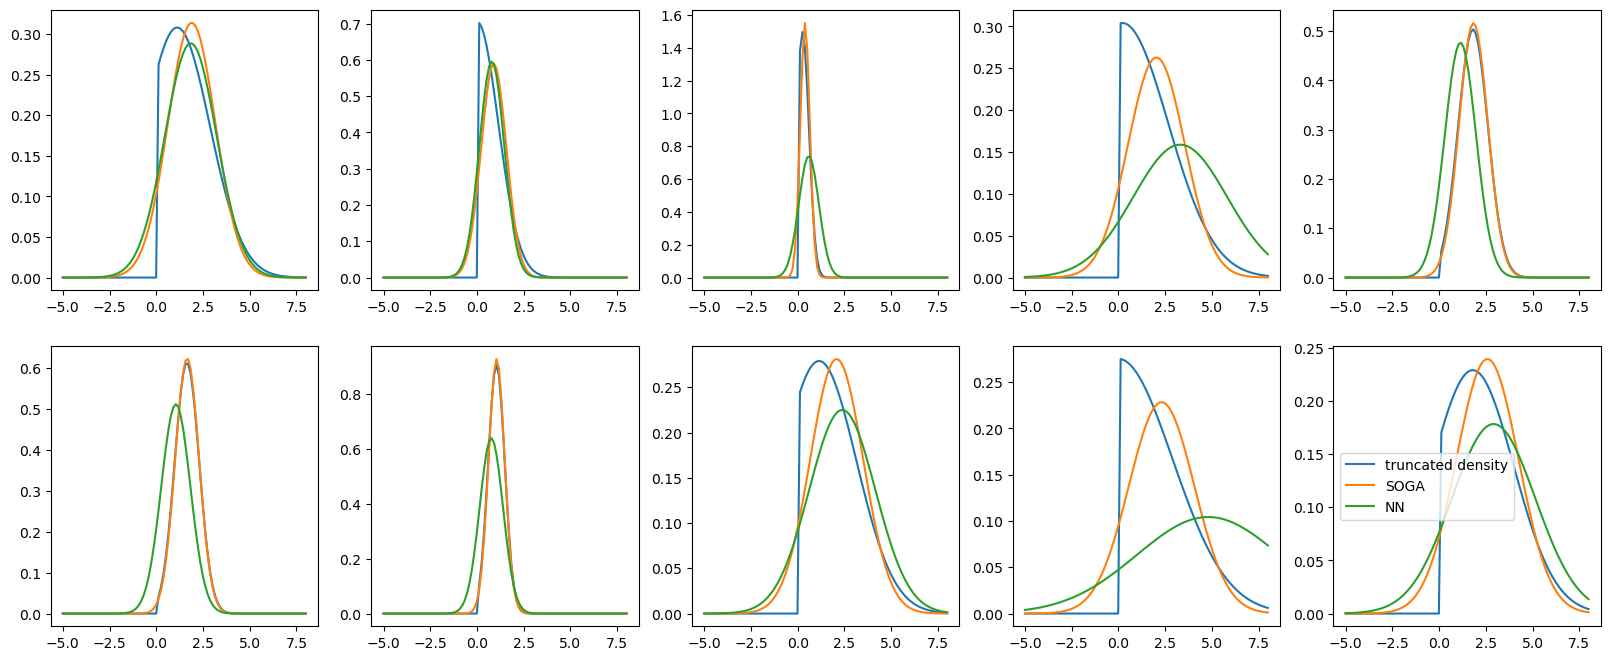

In [35]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = np.linspace(-5,8,100)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.figure(figsize=(20,8))

for i in range(10):

    loc = test_means[i]
    scale = np.sqrt(test_covs[i])
    a = -loc/scale
    b = np.inf

    y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
    y_soga = norm.pdf(x, soga_means[i], np.sqrt(soga_covs[i])).reshape(x.shape)
    y_nn = norm.pdf(x, pred_means[i].detach().numpy(), np.sqrt(pred_covs[i].detach().numpy())).reshape(x.shape)
    
    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_soga, label='SOGA')
    plt.plot(x, y_nn, label='NN')

plt.legend()

## Training 30 epoch

In [36]:
epochs = 30

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    losses = train_loop_minibatch(samples_dataset, model, loss_function_minibatch, optimizer)

print("Done!")
torch.save(model, 'params/truncNNdim1-direct-30ep-1to1.pth')


Epoch 1
-------------------------------
loss: 2173.567871
loss: 897.089722

Epoch 2
-------------------------------
loss: 383.755249
loss: 159.951996

Epoch 3
-------------------------------
loss: 237.030960
loss: 133.782669

Epoch 4
-------------------------------
loss: 135.830719
loss: 148.206253

Epoch 5
-------------------------------
loss: 154.411850
loss: 120.066521

Epoch 6
-------------------------------
loss: 139.813400
loss: 134.780380

Epoch 7
-------------------------------
loss: 126.726555
loss: 118.920731

Epoch 8
-------------------------------
loss: 112.015739
loss: 140.309296

Epoch 9
-------------------------------
loss: 116.193443
loss: 110.001907

Epoch 10
-------------------------------
loss: 96.352707
loss: 103.583481

Epoch 11
-------------------------------
loss: 107.290298
loss: 106.445618

Epoch 12
-------------------------------
loss: 87.354195
loss: 76.917671

Epoch 13
-------------------------------
loss: 64.211166
loss: 81.821617

Epoch 14
---------------

In [38]:
torch.save(model, 'params/truncNNdim1-direct-1to1-30ep.pth')

### Test

In [39]:
ncomp = 1
xdim = 1
nsamples = 500

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
model = torch.load('params/truncNNdim1-direct-1to1-30ep.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_15468\2369674756.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-direct-1to1-30ep.pth'

In [41]:
test_means = []
test_covs = []
pred_means = []
pred_covs = []

for i in range(10):
    
    test_means.append(torch.empty(ncomp, xdim).uniform_(0, 2))
    test_covs.append(torch.empty(ncomp, xdim, xdim))

    for j in range(ncomp):
      test_covs[-1] = generate_random_covariance(xdim, -5, 5)

    pi_pred, mu_pred, sigma_pred = model(torch.tensor([[1., test_means[-1], test_covs[-1]]]))
    pred_means.append(mu_pred)
    pred_covs.append(sigma_pred)

In [42]:
import libSOGA

soga_means = []
soga_covs = []

for i in range(10):
    soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[i][0])], [np.array(test_covs[i][0])]))
    _, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

    soga_means.append(new_soga_dist.gm.mu[0])
    soga_covs.append(new_soga_dist.gm.sigma[0])

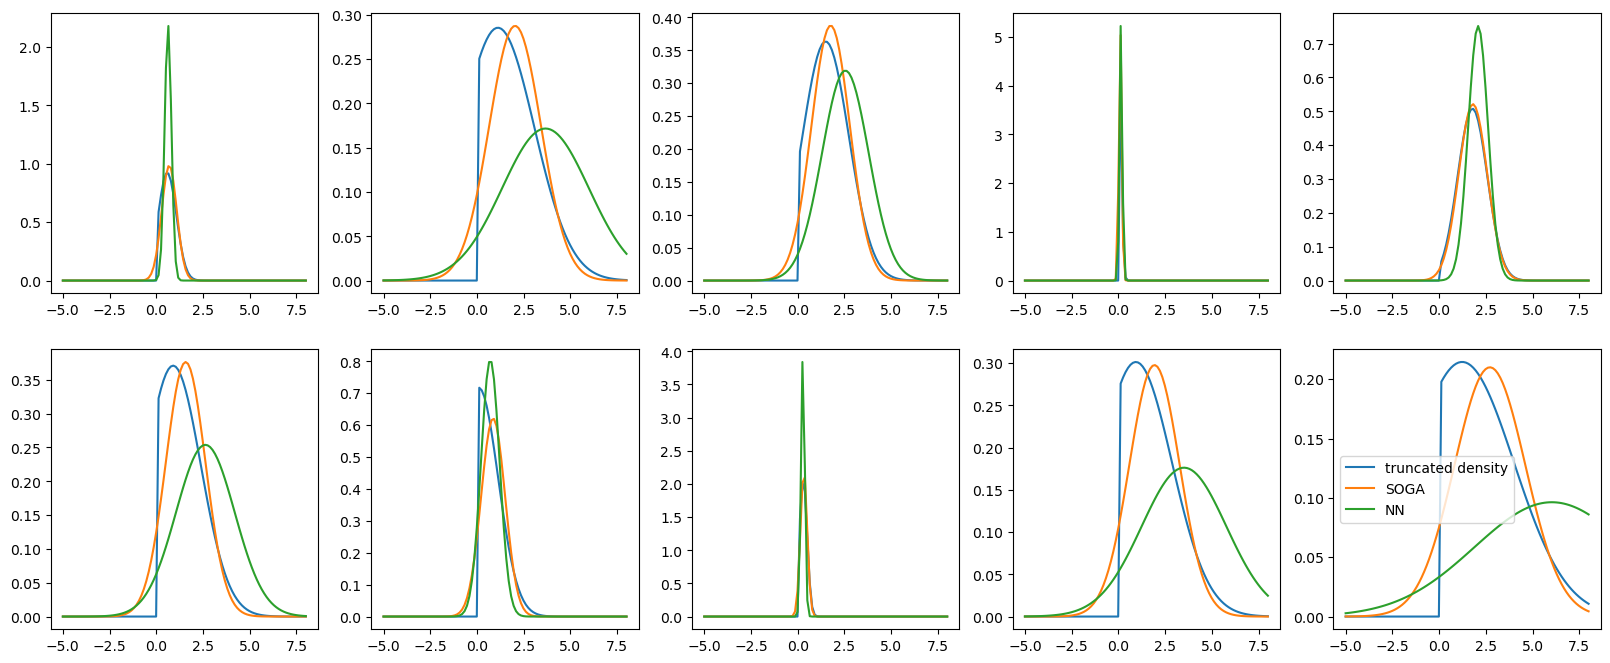

In [43]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = np.linspace(-5,8,100)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.figure(figsize=(20,8))

for i in range(10):

    loc = test_means[i]
    scale = np.sqrt(test_covs[i])
    a = -loc/scale
    b = np.inf

    y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
    y_soga = norm.pdf(x, soga_means[i], np.sqrt(soga_covs[i])).reshape(x.shape)
    y_nn = norm.pdf(x, pred_means[i].detach().numpy(), np.sqrt(pred_covs[i].detach().numpy())).reshape(x.shape)
    
    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_soga, label='SOGA')
    plt.plot(x, y_nn, label='NN')

plt.legend()